Tugas Besar Mata Kuliah MS3131 Analisis Aliran Material dan Informasi  

David 13120108  

Judul: Sistem Pendeteksi Anomali (Predictive Maintenance) pada Mesin Bubut dengan Metode Analisis Getaran 

#### Importing libraries and package

<p>Ada beberapa library yang perlu diimport terlebih dahulu, antara lain:</p>
<li>pandas dan numpy untuk keperluan aplikasi statistik</li>
<li>matplotlib untuk melakukan visualisasi data</li>
<li>pyodbc untuk menghubungkan python dengan basis data MySQL</li>

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
import pyodbc
%matplotlib inline


#### Data preview using pandas

In [2]:
dataframe = pd.read_csv(r"C:\Users\David\Documents\coding\Project\Tubes-AAMI\data_collected.csv")
dataframe['Timestamp'] = pd.to_datetime(dataframe['Timestamp'])
#dataframe.set_index('Timestamp', inplace=True)
dataframe.head()

,Timestamp,accx,accy,accz
0,2022-12-15 11:04:18.657,9.96,-0.55,1.03
1,2022-12-15 11:04:19.656,9.99,-0.51,0.84
2,2022-12-15 11:04:20.656,9.94,-0.53,1.16
3,2022-12-15 11:04:21.672,9.96,-0.52,0.89
4,2022-12-15 11:04:22.672,9.92,-0.50,1.07


#### Uploading dataset to MySQL

In [3]:
conn = pyodbc.connect('DSN=Tubes AAMI;User ID=8f68d_davidho;Password=123asdqwe')

cursor = conn.cursor()

In [4]:
"""
for row in dataframe.itertuples():
    cursor.execute('''
    INSERT INTO tubes_aami(Timestamp, accx, accy, accz) VALUES (?, ?, ?, ?)
    ''',
        row.Timestamp,
        row.accx,
        row.accy,
        row.accz
    )

    conn.commit()
"""

"\nfor row in dataframe.itertuples():\n    cursor.execute('''\n    INSERT INTO tubes_aami(Timestamp, accx, accy, accz) VALUES (?, ?, ?, ?)\n    ''',\n        row.Timestamp,\n        row.accx,\n        row.accy,\n        row.accz\n    )\n\n    conn.commit()\n"

#### Configurating Train Test

In [5]:
dataframe.set_index('Timestamp', inplace=True)
dataframe.head()

,accx,accy,accz
Timestamp,,,
2022-12-15 11:04:18.657,9.96,-0.55,1.03
2022-12-15 11:04:19.656,9.99,-0.51,0.84
2022-12-15 11:04:20.656,9.94,-0.53,1.16
2022-12-15 11:04:21.672,9.96,-0.52,0.89
2022-12-15 11:04:22.672,9.92,-0.50,1.07


<AxesSubplot: xlabel='Timestamp'>

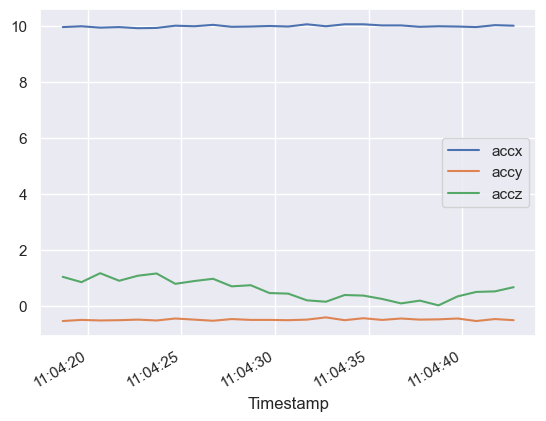

In [6]:
dataset_train = dataframe.iloc[:25]
dataset_test = dataframe.iloc[25:]
dataset_train.plot()

#### Normalizing Data Using Preprocessing Library

In [7]:
scaler = preprocessing.MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(dataset_train), columns=dataset_train.columns, index=dataset_train.index)

# Random shuffle training data
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(dataset_test), columns=dataset_test.columns, index=dataset_test.index)

#### Set Up PCA Modelling

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='full')

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = X_train.index


X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = X_test.index



#### Covariance Matrix Calculation

In [9]:
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False


def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Onverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite")

#### Mahalanobis Distance Calculation

In [10]:
def MahalanobistDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data-vars_mean
    md=[]
    for i in range (len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

#### Detecting outliers

In [11]:
def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range (len(dist)):
        if dist[i] >= threshold:
            outliers.append(i) # index of outlier
    return np.array(outliers)

#### Calculate the threshold value for classifying datapoint as anomaly

In [12]:
def MD_threshold(dist, extreme=False, verbose=False):
    k = 2. if extreme else 1. 
    threshold = np.mean(dist) * k
    return threshold

#### Setup PCA Model

In [13]:
data_train = np.array(X_train_PCA.values)
data_test = np.array(X_test_PCA.values)

#calculate the covariance matrix and its inverse
cov_matrix, inv_cov_matrix = cov_matrix(data_train)
#calculate the mean value for input variables in the training set
mean_distr = data_train.mean(axis=0)

In [14]:
print(mean_distr)

[1.15185639e-16 6.66133815e-18]


In [15]:
# Determining baseline

dist_test = MahalanobistDist(inv_cov_matrix, mean_distr, data_test, verbose=False)
dist_train = MahalanobistDist(inv_cov_matrix, mean_distr, data_train, verbose=False)
threshold = MD_threshold(dist_train, extreme=True)

#### Visualizing the square of Mahalanobis Distance and Its Original Value

Text(0.5, 12.44444444444443, 'Mahalanobis Distance')

<Figure size 640x480 with 0 Axes>

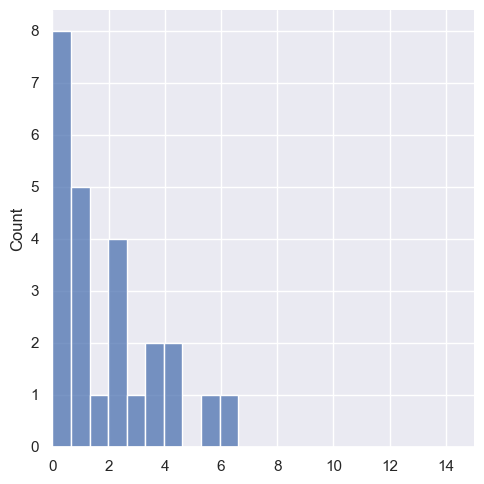

<Figure size 640x480 with 0 Axes>

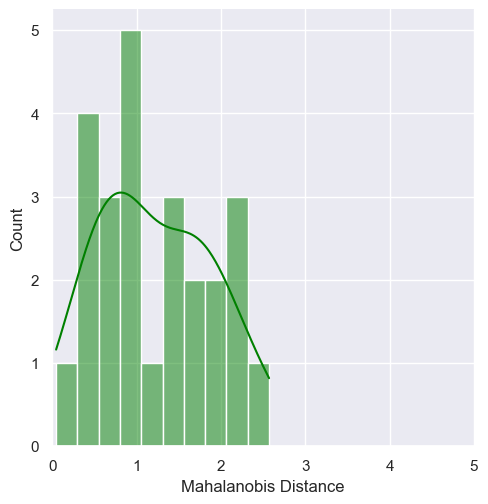

In [16]:
plt.figure()
sns.displot(np.square(dist_train), bins=10, kde=False);
plt.xlim([0.0,15])

#Visualize the Maahalanobis Distance

plt.figure()
sns.displot(dist_train, bins=10, kde=True, color = 'green');
plt.xlim([0.0, 5])
plt.xlabel('Mahalanobis Distance')

#### Anomaly Flagging Method

<AxesSubplot: xlabel='Timestamp'>

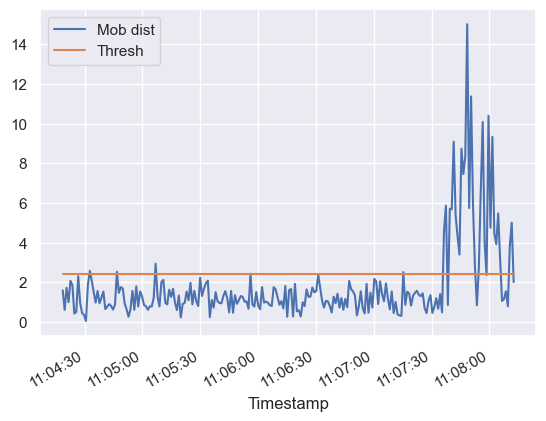

In [17]:
anomaly_train = pd.DataFrame()
anomaly_train['Mob dist'] = dist_train
anomaly_train['Thresh'] = threshold

# If mob dist above threshold: flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
anomaly_train.index = X_train_PCA.index
anomaly_train.head()

anomaly = pd.DataFrame()
anomaly['Mob dist'] = dist_test
anomaly['Thresh'] = threshold

#If mob dist abobe threshold: flag as anomaly
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
anomaly.index = X_test_PCA.index
anomaly.head()

#Merging the data
anomaly_alldata = pd.concat([anomaly_train, anomaly])

#Final plot
anomaly_alldata.plot()